In [1]:
from GoogleAuth import gcp_API
from dateutil.parser import parser
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import googlemaps
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
df14 = pd.read_csv('mass_shootings2014.csv', parse_dates=['Incident Date'])
df15 = pd.read_csv('mass_shootings2015.csv', parse_dates=['Incident Date'])
df16 = pd.read_csv('mass_shootings2016.csv', parse_dates=['Incident Date'])
df17 = pd.read_csv('mass_shootings2017.csv', parse_dates=['Incident Date'])
df18 = pd.read_csv('mass_shootings2018.csv', parse_dates=['Incident Date'])
df19 = pd.read_csv('mass_shootings2019.csv', parse_dates=['Incident Date'])
df20 = pd.read_csv('mass_shootings2020.csv', parse_dates=['Incident Date'])

frames = [df20, df19, df18, df17, df16, df15, df14]
df = pd.concat(frames, ignore_index=True, sort=True)
df.head()

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
0,6,0,485 N Clinton Ave,Rochester,2020-07-11,1731349.0,NaN,New York
1,5,0,7900 block of Janna Lee Ave,Alexandria,2020-07-07,1727743.0,NaN,Virginia
2,3,4,Harrison St and Carroll St,Paterson,2020-07-07,1728683.0,NaN,New Jersey
3,6,0,1305 W 76th St,Chicago,2020-07-06,1727567.0,NaN,Illinois
4,4,0,3700 block of W Jackson Blvd,Chicago,2020-07-05,1725883.0,NaN,Illinois


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 8 columns):
# Injured         2373 non-null int64
# Killed          2373 non-null int64
Address           2368 non-null object
City Or County    2373 non-null object
Incident Date     2373 non-null datetime64[ns]
Incident ID       889 non-null float64
Operations        0 non-null float64
State             2373 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 148.4+ KB


In [4]:
df.describe(include='all')

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
count,2373.000000,2373.000000,2368,2373,2373,8.890000e+02,0.0,2373
unique,NaN,NaN,2361,761,1328,NaN,NaN,48
top,NaN,NaN,6200 block of S King Dr,Chicago,2020-07-05 00:00:00,NaN,NaN,California
freq,NaN,NaN,2,172,15,NaN,NaN,256
first,NaN,NaN,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2020-07-11 00:00:00,NaN,NaN,NaN
mean,4.211547,1.094817,NaN,NaN,NaN,7.301707e+05,NaN,NaN
std,9.278886,2.294291,NaN,NaN,NaN,6.598323e+05,NaN,NaN
min,0.000000,0.000000,NaN,NaN,NaN,9.219400e+04,NaN,NaN
25%,3.000000,0.000000,NaN,NaN,NaN,2.103630e+05,NaN,NaN


In [5]:
df.sort_values(['# Killed', '# Injured'], ascending=False).head(20)

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
1112,441,59,3950 Las Vegas Blvd S,Las Vegas,2017-10-01,NaN,NaN,Nevada
1633,53,50,1912 S Orange Ave,Orlando,2016-06-12,NaN,NaN,Florida
1078,20,27,216 4th St,Sutherland Springs,2017-11-05,NaN,NaN,Texas
458,23,23,7101 Gateway Blvd,El Paso,2019-08-03,NaN,NaN,Texas
1012,17,17,5901 Pine Island Rd,Pompano Beach (Parkland),2018-02-14,NaN,NaN,Florida
1787,19,16,1365 South Waterman Avenue,San Bernardino,2015-12-02,456893.0,NaN,California
555,4,13,2405 Courthouse Drive,Virginia Beach,2019-05-31,NaN,NaN,Virginia
733,2,13,99 Rolling Oaks Dr,Thousand Oaks,2018-11-07,NaN,NaN,California
745,7,11,5898 Wilkins Ave,Pittsburgh,2018-10-27,NaN,NaN,Pennsylvania
457,17,10,419 E 5th St,Dayton,2019-08-04,NaN,NaN,Ohio


In [6]:
df.sort_values(['# Injured', '# Killed'], ascending=False).head(20)

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
1112,441,59,3950 Las Vegas Blvd S,Las Vegas,2017-10-01,NaN,NaN,Nevada
1633,53,50,1912 S Orange Ave,Orlando,2016-06-12,NaN,NaN,Florida
1207,25,0,220 W 6th St,Little Rock,2017-07-01,NaN,NaN,Arkansas
458,23,23,7101 Gateway Blvd,El Paso,2019-08-03,NaN,NaN,Texas
422,23,8,8250 TX 191,Odessa,2019-08-31,NaN,NaN,Texas
1078,20,27,216 4th St,Sutherland Springs,2017-11-05,NaN,NaN,Texas
1787,19,16,1365 South Waterman Avenue,San Bernardino,2015-12-02,456893.0,NaN,California
1563,19,2,3580 Evans Ave,Fort Myers,2016-07-25,NaN,NaN,Florida
910,19,1,635 S Clinton Ave,Trenton,2018-06-17,NaN,NaN,New Jersey
2006,18,9,4671 S Jack Kultgen Fwy,Waco,2015-05-17,341622.0,NaN,Texas


In [7]:
df.loc[df['# Injured']>df['# Killed']].index.value_counts().sum()

1980

In [8]:
df[df.duplicated(['Address'], keep=False)]

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
20,5,0,NaN,Red Oak,2020-07-04,1725735.0,NaN,South Carolina
48,1,3,600 block of Parkway Dr,Blytheville,2020-06-27,1719645.0,NaN,Arkansas
380,5,0,1127 Chestnut St,Evansville,2019-10-06,NaN,NaN,Indiana
395,6,0,101 W Maryland St,Indianapolis,2019-09-21,NaN,NaN,Indiana
415,4,0,6200 block of S King Dr,Chicago,2019-09-02,NaN,NaN,Illinois
515,7,0,600 block of Parkway Dr,Atlanta,2019-06-27,NaN,NaN,Georgia
596,4,0,101 W Maryland St,Indianapolis,2019-05-04,NaN,NaN,Indiana
747,5,0,6200 block of S King Dr,Chicago,2018-10-24,NaN,NaN,Illinois
791,4,0,NaN,Jacksonville,2018-09-09,NaN,NaN,Florida
993,7,0,2928 W Kentucky St,Louisville,2018-03-17,NaN,NaN,Kentucky


In [9]:
df[df.duplicated(['Address', 'City Or County'], keep=False)]

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
380,5,0,1127 Chestnut St,Evansville,2019-10-06,NaN,NaN,Indiana
395,6,0,101 W Maryland St,Indianapolis,2019-09-21,NaN,NaN,Indiana
415,4,0,6200 block of S King Dr,Chicago,2019-09-02,NaN,NaN,Illinois
596,4,0,101 W Maryland St,Indianapolis,2019-05-04,NaN,NaN,Indiana
747,5,0,6200 block of S King Dr,Chicago,2018-10-24,NaN,NaN,Illinois
993,7,0,2928 W Kentucky St,Louisville,2018-03-17,NaN,NaN,Kentucky
1143,3,1,1127 Chestnut St,Evansville,2017-08-27,NaN,NaN,Indiana
1921,6,0,2928 W Kentucky St,Louisville,2015-07-19,377047.0,NaN,Kentucky


In [12]:
df.iat[1784,3]='Cincinnati'

In [13]:
sorted(df.State.unique().tolist())

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [14]:
cities_df = df.drop(df.columns[[2,4,5,6]], axis=1).groupby(['City Or County', 'State']).sum().sort_values(['# Injured', '# Killed'], ascending=False)
cities_df['# Incidents'] = df.drop(df.columns[[0,1,2,5,6]], axis=1).groupby(['City Or County', 'State']).count()
cities_df.head(50)

,,# Injured,# Killed,# Incidents
City Or County,State,,,
Chicago,Illinois,727,108,172
Las Vegas,Nevada,484,72,14
Philadelphia,Pennsylvania,242,40,59
Baltimore,Maryland,213,28,52
New Orleans,Louisiana,204,36,43
Memphis,Tennessee,189,23,45
Saint Louis,Missouri,176,49,50
Washington,District of Columbia,153,13,35
Houston,Texas,149,60,42


In [15]:
cities_df.loc[['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island']]

,,# Injured,# Killed,# Incidents
City Or County,State,,,
Brooklyn,New York,130,11,29
Bronx,New York,59,3,13
Queens,New York,15,1,4
Manhattan,New York,4,0,1


In [16]:
df.drop(df.columns[[0,1,2,3,5,6]], axis=1).groupby('State').count().sort_values('Incident Date', ascending=False)

,Incident Date
State,
California,256
Illinois,238
Texas,153
Florida,152
Louisiana,104
Pennsylvania,101
New York,101
Georgia,98
Ohio,87


In [17]:
yearly_df = df.groupby(df['Incident Date'].map(lambda x: x.year)).sum().drop(df.columns[[5,6]],axis=1)
yearly_df['# Incidents'] = df.groupby(df['Incident Date'].map(lambda x: x.year)).count().drop(df.columns[[0,1,2,3,5,6,7]],axis=1)
yearly_df

,# Injured,# Killed,# Incidents
Incident Date,,,
2014,1079,262,269
2015,1337,368,335
2016,1538,451,382
2017,1803,437,346
2018,1340,372,338
2019,1710,465,418
2020,1187,243,285


In [18]:
yearly_df.pct_change().round(5)*100

,# Injured,# Killed,# Incidents
Incident Date,,,
2014,NaN,NaN,NaN
2015,23.911,40.458,24.535
2016,15.034,22.554,14.030
2017,17.230,-3.104,-9.424
2018,-25.679,-14.874,-2.312
2019,27.612,25.000,23.669
2020,-30.585,-47.742,-31.818


In [25]:
state_df = df.groupby([df['Incident Date'].map(lambda x: x.year), df['State']]).agg('count').drop(df.columns[[0,1,2,3,5,6]],axis=1).rename(columns={'Incident Date': 'Number of Incidents'})
group = state_df['Number of Incidents'].groupby(level=0, group_keys=False)
group.nlargest(5)

Incident Date  State       
2014           California      41
               Illinois        26
               Georgia         17
               Florida         16
               New York        14
2015           California      27
               Florida         25
               Illinois        25
               New York        21
               Georgia         20
2016           California      46
               Illinois        42
               Texas           31
               Florida         30
               Georgia         17
2017           California      37
               Illinois        36
               Florida         24
               Texas           22
               Ohio            21
2018           California      35
               Illinois        35
               Florida         30
               Pennsylvania    19
               Tennessee       18
2019           California      49
               Illinois        41
               Texas           31
               Louis

In [44]:
group.rank(method='first', ascending=False).groupby(level=0, group_keys=False).nsmallest(10).unstack(level='State')

State,Alabama,California,Florida,Georgia,Illinois,Louisiana,Maryland,Michigan,Mississippi,Missouri,New Jersey,New York,North Carolina,Ohio,Pennsylvania,South Carolina,Tennessee,Texas
Incident Date,,,,,,,,,,,,,,,,,,
2014,NaN,1.0,4.0,3.0,2.0,8.0,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,10.0,NaN,7.0,6.0
2015,NaN,1.0,2.0,5.0,3.0,8.0,10.0,NaN,NaN,NaN,NaN,4.0,NaN,9.0,7.0,NaN,NaN,6.0
2016,6.0,1.0,4.0,5.0,2.0,8.0,10.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,9.0,3.0
2017,NaN,1.0,3.0,NaN,2.0,6.0,NaN,NaN,9.0,NaN,10.0,NaN,NaN,5.0,7.0,NaN,8.0,4.0
2018,7.0,1.0,3.0,NaN,2.0,9.0,NaN,NaN,NaN,8.0,NaN,10.0,NaN,NaN,4.0,NaN,5.0,6.0
2019,NaN,1.0,9.0,6.0,2.0,4.0,5.0,NaN,NaN,8.0,NaN,NaN,NaN,10.0,7.0,NaN,NaN,3.0
2020,NaN,2.0,7.0,NaN,1.0,8.0,NaN,NaN,NaN,5.0,NaN,4.0,9.0,NaN,6.0,10.0,NaN,3.0


In [22]:
group[group.columns[~group.isna().any()]]

State,California,Florida,Illinois,Louisiana,Texas
Incident Date,,,,,
2014,41.0,16.0,26.0,11.0,14.0
2015,27.0,25.0,25.0,14.0,19.0
2016,46.0,30.0,42.0,13.0,31.0
2017,37.0,24.0,36.0,15.0,22.0
2018,35.0,30.0,35.0,13.0,16.0
2019,49.0,15.0,41.0,26.0,31.0
2020,21.0,12.0,33.0,12.0,20.0


In [11]:
def get_geocode(address):
    gmaps = googlemaps.Client(key=gcp_API)
    geocode_result = gmaps.geocode(address)
    return geocode_result[0]['geometry']['location'].values() if geocode_result else (None, None)

In [12]:
df['Full Address'] = df['Address'] + ' ' + df['City Or County'] + ', ' + df['State'] if not df['Address'].empty else ''
test_df = df['Full Address'].map(lambda x: get_geocode(x) if x else None)
df['Latitude'] = test_df.map(lambda x: list(x)[0]).tolist()
df['Longitude'] = test_df.map(lambda x: list(x)[1]).tolist()

In [136]:
# df.to_csv('mass_shootings.csv', index=False)

In [2]:
df = pd.read_csv('mass_shootings.csv', parse_dates=['Incident Date'])
df.head()

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State,Full Address,Latitude,Longitude
0,6,0,485 N Clinton Ave,Rochester,2020-07-11,1731349.0,NaN,New York,"485 N Clinton Ave Rochester, New York",43.166601,-77.610920
1,5,0,7900 block of Janna Lee Ave,Alexandria,2020-07-07,1727743.0,NaN,Virginia,"7900 block of Janna Lee Ave Alexandria, Virginia",38.746103,-77.094781
2,3,4,Harrison St and Carroll St,Paterson,2020-07-07,1728683.0,NaN,New Jersey,"Harrison St and Carroll St Paterson, New Jersey",40.922841,-74.161575
3,6,0,1305 W 76th St,Chicago,2020-07-06,1727567.0,NaN,Illinois,"1305 W 76th St Chicago, Illinois",41.755545,-87.656744
4,4,0,3700 block of W Jackson Blvd,Chicago,2020-07-05,1725883.0,NaN,Illinois,"3700 block of W Jackson Blvd Chicago, Illinois",41.877205,-87.718212


In [46]:
output_notebook()

map_options = GMapOptions(lat=37.0625, lng=-95.677068, map_type="roadmap", zoom=3)

p = gmap(gcp_API, map_options, title="USA")

source = ColumnDataSource(
    data=dict(lat=df['Latitude'].tolist(),
              lon=df['Longitude'].tolist())
)

p.circle(x="lon", y="lat", size=8, fill_color="orange", fill_alpha=0.8, source=source)

show(p)


Loading BokehJS ...

In [47]:
chicago_df = df.loc[(df['City Or County']=='Chicago') & (df['State']=='Illinois')]
chicago_df['# Victims'] = chicago_df[['# Injured', '# Killed']].sum(axis=1)
chicago_df = chicago_df.drop(chicago_df.columns[[0,1,2,3,5,6,7]], axis=1).set_index('Incident Date')
chicago_df.loc[chicago_df.index.year==2014]

/Users/tzulungs/opt/anaconda3/envs/mlearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Full Address,Latitude,Longitude,# Victims
Incident Date,,,,
2014-12-22,"5700 block of South Green Street Chicago, Illi...",41.790482,-87.646624,5
2014-11-19,"700 block of North St. Louis Avenue Chicago, I...",41.893646,-87.713804,4
2014-08-24,"8300 block of South Halsted Street Chicago, Il...",41.743211,-87.644335,4
2014-07-25,"700 South California Avenue Chicago, Illinois",41.872696,-87.696300,7
2014-07-19,"1300 North Mason Avenue Chicago, Illinois",41.903951,-87.774508,4
2014-07-11,"5200 West Quincy Street Chicago, Illinois",41.877689,-87.755419,4
2014-06-04,"4900 West West End Avenue Chicago, Illinois",41.883270,-87.748186,4
2014-06-02,"2660 E. 79th St Chicago, Illinois",41.752129,-87.559112,7
2014-06-01,West Ferdinand Street and North Lavergne Avenu...,41.889518,-87.750493,6


In [48]:
def mercator(latitude, longitude):
    xlist, ylist = [], []
    r_major = 6378137.000
    for lat, lon in zip(latitude, longitude):
        x = r_major * math.radians(lon)
        scale = x/lon
        y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
            lat * (math.pi/180.0)/2.0)) * scale
        xlist.append(x)
        ylist.append(y)
    return (xlist, ylist)

In [49]:
latitude, longitude = chicago_df['Latitude'].tolist(), chicago_df['Longitude'].tolist()
chicago_df['X Coordinate'], chicago_df['Y Coordinate'] = mercator(latitude, longitude)
chicago_df.head()

,Full Address,Latitude,Longitude,# Victims,X Coordinate,Y Coordinate
Incident Date,,,,,,
2020-07-06,"1305 W 76th St Chicago, Illinois",41.755545,-87.656744,6,-9.757904e+06,5.124431e+06
2020-07-05,"3700 block of W Jackson Blvd Chicago, Illinois",41.877205,-87.718212,4,-9.764747e+06,5.142603e+06
2020-07-05,"1500 block of S Millard Ave Chicago, Illinois",41.860771,-87.716466,6,-9.764552e+06,5.140146e+06
2020-07-04,"8300 block of S Kingston Ave Chicago, Illinois",41.744497,-87.562480,4,-9.747411e+06,5.122783e+06
2020-07-04,"6100 block of S Carpenter St Chicago, Illinois",41.783300,-87.650918,8,-9.757256e+06,5.128574e+06


In [51]:
output_notebook()
p = figure(x_range=(-9765000, -9745000), y_range=(5105000, 5173000),
           x_axis_type='mercator', y_axis_type='mercator')

tile_provider = get_provider(Vendors.CARTODBPOSITRON)
p.add_tile(tile_provider)

years = chicago_df.index.year.unique().tolist()[::-1]
colors = ['green', 'orange', 'red', 'purple', 'blue', 'pink', 'grey']

for year, color in zip(years, colors):
    p.circle(x=chicago_df.loc[chicago_df.index.year==year]['X Coordinate'],
             y=chicago_df.loc[chicago_df.index.year==year]['Y Coordinate'],
             size=(chicago_df.loc[chicago_df.index.year==year]['# Victims']*3).tolist(),
             legend_label=f'{year} Shootings', line_color=color, fill_color=color, fill_alpha=0.3)

show(p)

Loading BokehJS ...

In [4]:
df = df.drop('Operations', axis=1)
df['# Victims'] = df.loc[:, ['# Injured', '# Killed']].sum(axis=1)
df.sort_values(['Incident Date', 'State'], inplace=True)
df['Cumulative Victims Same Year'] = df.groupby(df['Incident Date'].map(lambda x: x.year))['# Victims'].apply(lambda x: x.cumsum())
df.set_index('Incident Date', inplace=True)

In [5]:
ts_df = df.drop(['Address', 'City Or County', 'Incident ID', 'State', 'Latitude', 'Longitude'], axis=1)
ts_df = ts_df.resample('W').sum().drop('Cumulative Victims Same Year', axis=1)
ts_df.index.rename('Week Ending In', inplace=True)
ts_df['Cumulative Victims Same Year'] = ts_df.groupby(ts_df.index.map(lambda x: x.year))['# Victims'].apply(lambda x: x.cumsum())
ts_df['Year'], ts_df['Week #'] = ts_df.index.year, ts_df.index.week

In [54]:
ts_df

,# Injured,# Killed,# Victims,Cumulative Victims Same Year,Year,Week #
Week Ending In,,,,,,
2014-01-05,8,4,12,12,2014,1
2014-01-12,20,0,20,32,2014,2
2014-01-19,13,7,20,52,2014,3
2014-01-26,15,3,18,70,2014,4
2014-02-02,8,1,9,79,2014,5
...,...,...,...,...,...,...
2020-06-14,121,27,148,1006,2020,24
2020-06-21,95,9,104,1110,2020,25
2020-06-28,93,16,109,1219,2020,26


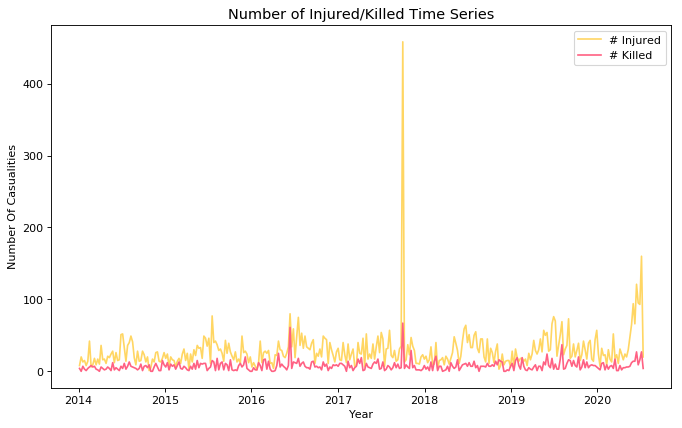

In [66]:
plt.figure(figsize=(10,6), dpi= 80)
category = ['# Injured', '# Killed']
colors = ['#ffd663', '#ff6183']
for ct, cl in zip(category, colors):    
    plt.plot(ct, data=ts_df, color=cl)
    
plt.gca().set(ylabel='Number Of Casualities', xlabel='Year')
plt.title("Number of Injured/Killed Time Series", fontsize=13)
plt.legend()
plt.show()

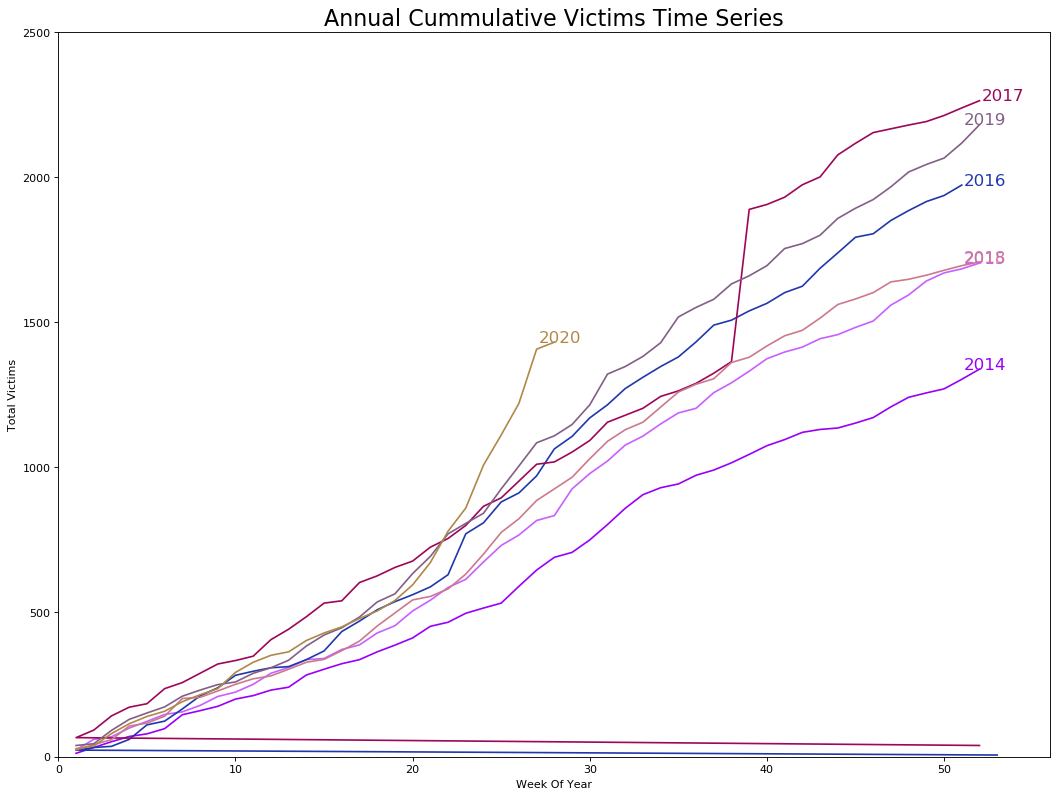

In [67]:
years = ts_df['Year'].unique().tolist()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):        
    plt.plot('Week #', 'Cumulative Victims Same Year', data=ts_df.drop(ts_df.columns[[0,1,2]], axis=1).loc[ts_df['Year']==y, :], color=mycolors[i], label=y)
    plt.text(ts_df.loc[ts_df['Year']==y, :].shape[0]-.9, ts_df.loc[ts_df['Year']==y, 'Cumulative Victims Same Year'][-1:].values[0], y, fontsize=15, color=mycolors[i])

plt.gca().set(xlim=(0, 56), ylim=(0, 2500), ylabel='Total Victims', xlabel='Week Of Year')
plt.title("Annual Cummulative Victims Time Series", fontsize=20)
plt.show()

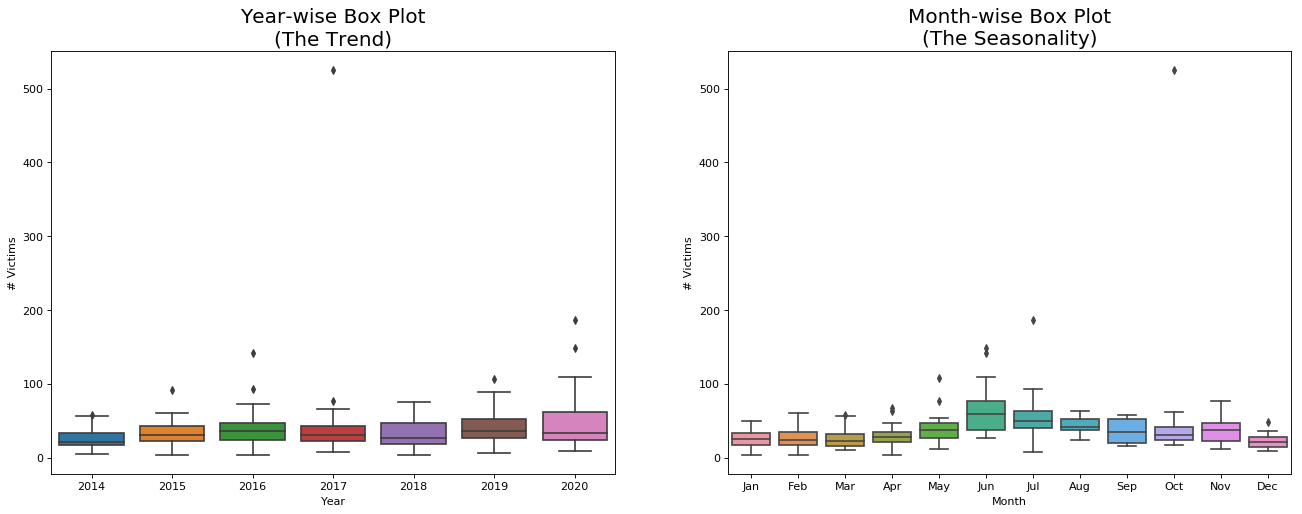

In [68]:
ts_df['Month'] = [d.strftime('%b') for d in ts_df.index]
years = ts_df['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Victims', data=ts_df, ax=axes[0])
sns.boxplot(x='Month', y='# Victims', data=ts_df.loc[~ts_df.Year.isin([2014, 2020]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()


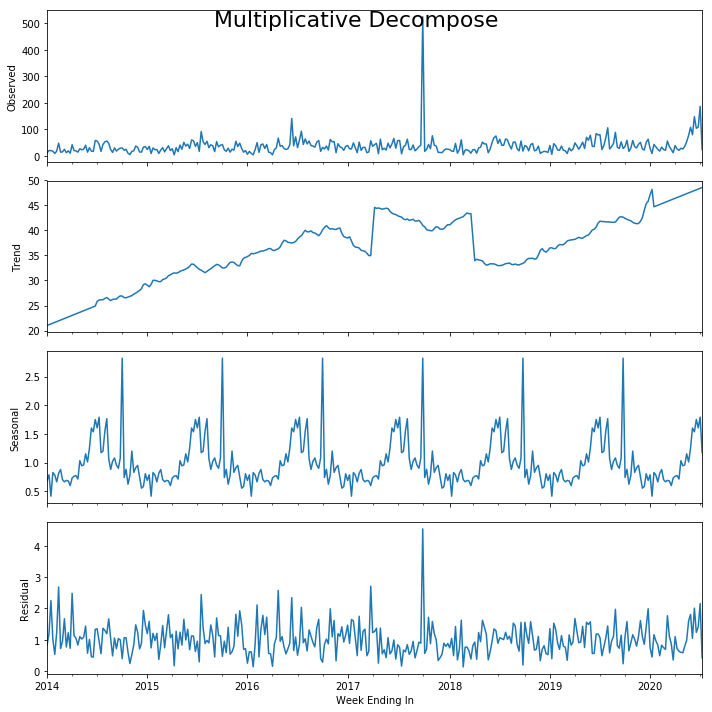

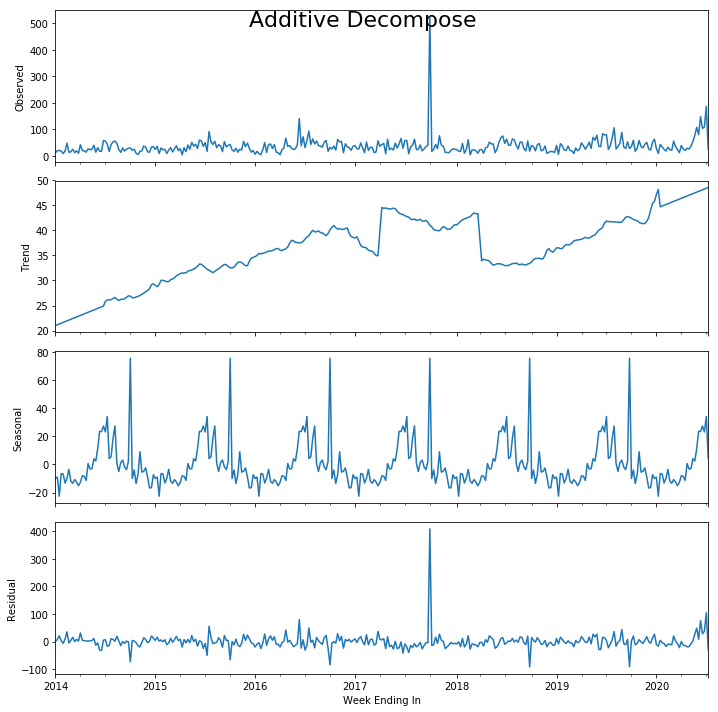

In [70]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(ts_df['# Victims'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ts_df['# Victims'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [76]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Week Ending In,,,,
2014-01-05,0.690659,21.013234,0.826846,12
2014-01-12,0.788755,21.168245,1.197852,20
2014-01-19,0.416586,21.323256,2.251499,20
2014-01-26,0.828350,21.478267,1.011717,18
2014-02-02,0.784556,21.633278,0.530269,9


In [72]:
result = adfuller(ts_df['# Victims'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.2697606279989015
p-value: 6.323232478903798e-06
Critial Values:
   1%, -3.449962981927952
Critial Values:
   5%, -2.870180642420163
Critial Values:
   10%, -2.5713734527352607


In [73]:
# KPSS Test
result = kpss(ts_df['# Victims'], regression='c', lags='auto')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.555532
p-value: 0.029159
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


[]

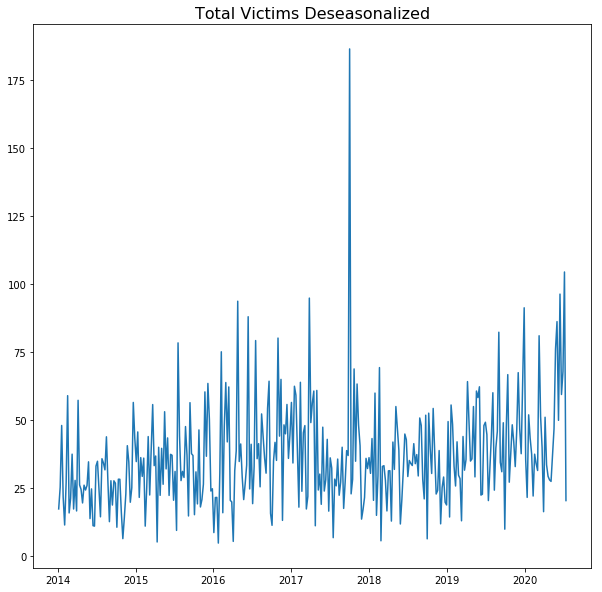

In [78]:
# Deseasonalize
deseasonalized = df_reconstructed['actual_values'] / df_reconstructed['seas']

# Plot
plt.plot(deseasonalized)
plt.title('Total Victims Deseasonalized', fontsize=16)
plt.plot()

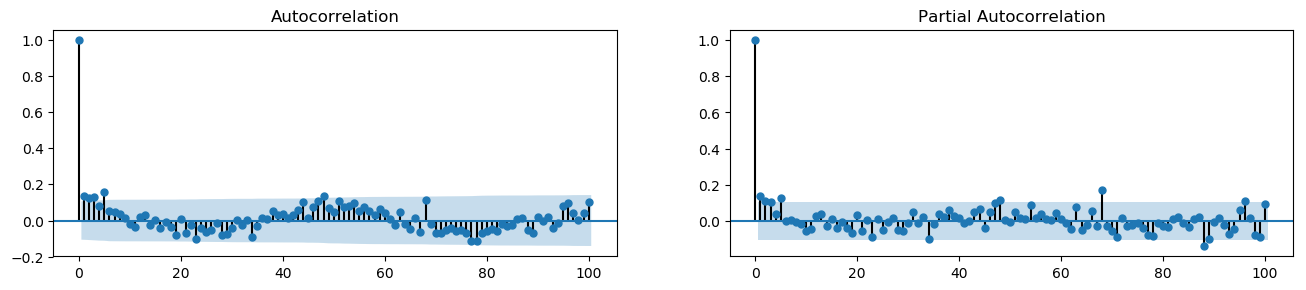

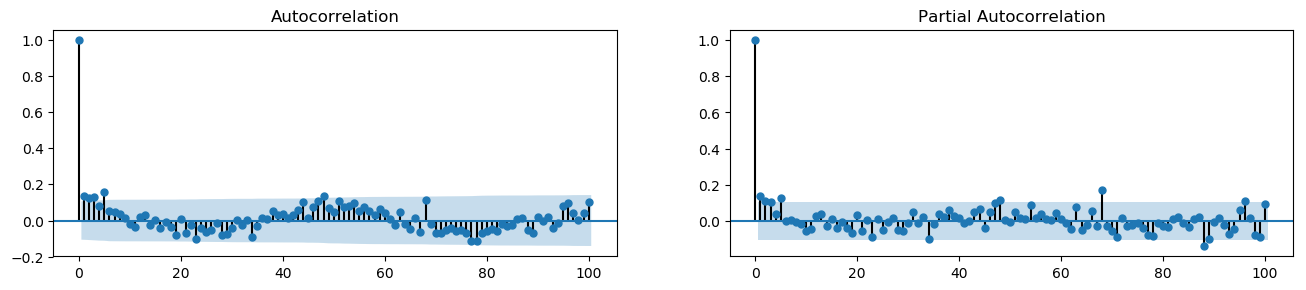

In [79]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(ts_df['# Victims'].tolist(), lags=100, ax=axes[0])
plot_pacf(ts_df['# Victims'].tolist(), lags=100, ax=axes[1])

In [114]:
# fit model
model = SARIMAX(ts_df[:'2019-12-29']['# Victims'], order=(0, 0, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit(disp=False)
# make prediction
residuals = pd.Series()
for i in range(13):
    yhat = model_fit.predict(len(ts_df[:'2019-12-29']['# Victims'])+i, len(ts_df[:'2019-12-29']['# Victims'])+i)
    print(yhat)
    if not residuals.empty:
        residuals = pd.concat([residuals, yhat - ts_df.loc[yhat.index, '# Victims']])
    else:
        residuals = yhat - ts_df.loc[yhat.index, '# Victims']
print("Mean Absolute Percent Error: ", round((abs(residuals)/ts_df.loc[residuals.index, '# Victims']).mean(), 4))
print("Root Mean Squared Error: ", round(((residuals**2).mean())**(1/2), 4))

2020-01-05    32.386733
Freq: W-SUN, dtype: float64
2020-01-12    11.290613
Freq: W-SUN, dtype: float64
2020-01-19    33.214351
Freq: W-SUN, dtype: float64
2020-01-26    41.96796
Freq: W-SUN, dtype: float64
2020-02-02    16.709387
Freq: W-SUN, dtype: float64
2020-02-09    22.322653
Freq: W-SUN, dtype: float64
2020-02-16    47.581227
Freq: W-SUN, dtype: float64
2020-02-23    13.504964
Freq: W-SUN, dtype: float64
2020-03-01    20.322653
Freq: W-SUN, dtype: float64
2020-03-08    15.172382
Freq: W-SUN, dtype: float64
2020-03-15    25.150271
Freq: W-SUN, dtype: float64
2020-03-22    15.03204
Freq: W-SUN, dtype: float64
2020-03-29    24.677347
Freq: W-SUN, dtype: float64
Mean Absolute Percent Error:  0.369
Root Mean Squared Error:  14.1406


In [91]:
ts_df.loc[(ts_df['Year']==2020) & (ts_df['Week #']<14)]

,# Injured,# Killed,# Victims,Cumulative Victims Same Year,Year,Week #,Month
Week Ending In,,,,,,,
2020-01-05,24,4,28,28,2020,1,Jan
2020-01-12,7,2,9,37,2020,2,Jan
2020-01-19,32,11,43,80,2020,3,Jan
2020-01-26,22,12,34,114,2020,4,Jan
2020-02-02,23,2,25,139,2020,5,Feb
2020-02-09,9,9,18,157,2020,6,Feb
2020-02-16,30,3,33,190,2020,7,Feb
2020-02-23,17,7,24,214,2020,8,Feb
2020-03-01,13,8,21,235,2020,9,Mar


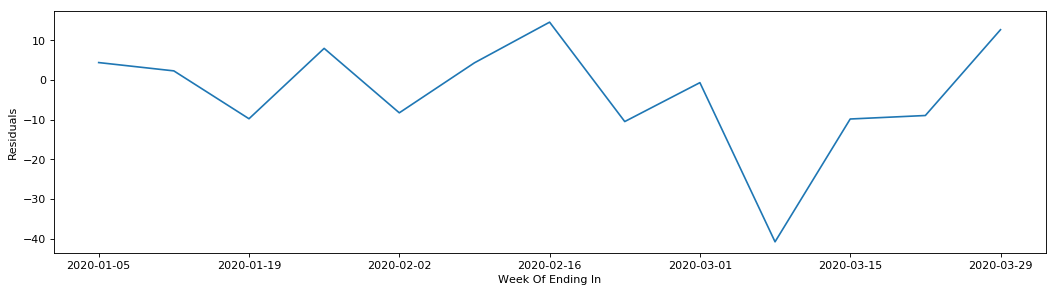

In [106]:
plt.figure(figsize=(16,4), dpi= 80)
plt.plot(residuals)
plt.gca().set(xticks=residuals.index.tolist()[::2], ylabel='Residuals', xlabel='Week Of Ending In')
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

In [117]:
result = adfuller(ts_df['# Injured'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# KPSS Test
result = kpss(ts_df['# Injured'], regression='c', lags='auto')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.330983384905101
p-value: 4.72189321316021e-06
Critial Values:
   1%, -3.449962981927952
Critial Values:
   5%, -2.870180642420163
Critial Values:
   10%, -2.5713734527352607

KPSS Statistic: 0.515966
p-value: 0.038071
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [118]:
result = adfuller(ts_df['# Killed'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# KPSS Test
result = kpss(ts_df['# Killed'], regression='c', lags='auto')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.640468434803387
p-value: 5.426156288488177e-09
Critial Values:
   1%, -3.449962981927952
Critial Values:
   5%, -2.870180642420163
Critial Values:
   10%, -2.5713734527352607

KPSS Statistic: 0.592319
p-value: 0.023335
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [119]:
ts_df['# Injured'].corr(ts_df['# Killed'])

0.6428223408314094

In [16]:
# fit model
model = VAR(ts_df[:'2018-12-30'][['# Injured', '# Killed']])
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=5)
print(yhat)

[[25.76172903  6.98913634]
 [27.17692671  7.23526013]
 [27.25086442  7.24099199]
 [27.25551852  7.24163478]
 [27.25578017  7.24166166]]


In [115]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [26]:
# fit model
data = ts_df[:'2018-12-30'][['# Injured', '# Killed']]
data['# Injured'] = data['# Injured'].astype(float)
data['# Killed'] = data['# Killed'].astype(float)
model = VARMAX(data, order=(3, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

            # Injured  # Killed
2019-01-06  24.208997  6.536858


In [126]:
gmaps = googlemaps.Client(key=gcp_API)
geocode_result = gmaps.geocode('Starkville, Mississippi')
geocode_result

[{'address_components': [{'long_name': 'Starkville',
    'short_name': 'Starkville',
    'types': ['locality', 'political']},
   {'long_name': 'Oktibbeha County',
    'short_name': 'Oktibbeha County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Mississippi',
    'short_name': 'MS',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '39759', 'short_name': '39759', 'types': ['postal_code']}],
  'formatted_address': 'Starkville, MS 39759, USA',
  'geometry': {'bounds': {'northeast': {'lat': 33.5062939, 'lng': -88.788859},
    'southwest': {'lat': 33.406288, 'lng': -88.87558609999999}},
   'location': {'lat': 33.4503998, 'lng': -88.81838719999999},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 33.5062939, 'lng': -88.788859},
    'southwest': {'lat': 33.406288, 'lng': -88.87558609999999}}},
  'place_id': 'ChIJ

In [127]:
lat, lng = geocode_result[0]['geometry']['location'].values()

In [128]:
lat

33.4503998

In [129]:
lng

-88.81838719999999

In [132]:
df.iloc[1893]

# Injured                           5
# Killed                            0
Address                           NaN
City Or County             Starkville
Incident Date     2014-03-30 00:00:00
Incident ID                    120621
Operations                        NaN
State                     Mississippi
Full Address                      NaN
Latitude                      33.4504
Longitude                    -88.8184
Name: 1893, dtype: object

In [48]:
output_file("gmap.html")

map_options = GMapOptions(lat=37.0625, lng=-95.677068, map_type="roadmap", zoom=3)

p = gmap(gcp_API, map_options, title="USA")

source = ColumnDataSource(
    data=dict(lat=df['Latitude'].tolist(),
              lon=df['Longitude'].tolist())
)

p.circle(x="lon", y="lat", size=8, fill_color="blue", fill_alpha=0.8, source=source)

show(p)
